This script produces the figures as shown in "Predicting Food-Security Crises in the Horn of Africa Using Machine Learning". 

In [1]:
#####################################################################################################################
################################################### IMPORT PACKAGES  ###################################################
#####################################################################################################################

from time import sleep
import os
import random as python_random
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import mapclassify as mc
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch

# SKLEARN 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,RandomizedSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, recall_score, precision_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

from sklearn.tree import export_graphviz
from sklearn import tree

from sklearn.feature_selection import SelectKBest

# Tensorflow
#import tensorflow as tf

# others
import pydot
## FEATURE EXPLANATION
import shap 
from colour import Color
import contextily as ctx
#import jupyterthemes as jt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
CORE= '/scistor/ivm/tbr910/ML/' #/scistor/ivm/tbr910/ML/ | C:/Users/tbr910/Documents/ML/
BASE= CORE+'ML_results/' # 'C:/Users/tbr910/Documents/ML/
VECTOR_FOLDER=CORE+'input_collector/Vector/'    
FSO_FOLDER= CORE+'input_collector/FC_data/FEWS/FEWS_OUTLOOKS'
paper_plots= CORE+'paper_figs/'

extent='HOA'
experiment= 'RUN_FINAL_PAPER_20' #EXP_POP_20 # REV_BASE_20
region_list=['HOA'] # region for which the model runned --> 'HOA' or 'Somalia','Kenya', 'Ethiopia'
aggregation='cluster' # county, cluster, all 
pop_weighted=True # used to choose the right prediction dataframe from FEWS internal predictions (the FEWS-NET outlooks spatially weighted to calculate county mean)

# crises onset variables 
method='crisis_onset'
threshold= 3 # threshold for crisis onset 
co_buffer=0.05 # this is the allowance of the crisis onset (co) threshold to deviate with this buffer. For example, turkana was 2.98 with the whole county in crisis except a very small area. We want this to still be classified as crisis onset. 

if aggregation=='county':
    region_list=['HOA']

if aggregation=='cluster':
    cluster_list=['ap','p','other'] # cluster you want to plot

if aggregation=='county':
    cluster_list=['no_cluster']
if aggregation=='all':
    cluster_list=['no_cluster']




In [3]:
preds_storage_master=pd.DataFrame()
features_df_full_master=pd.DataFrame()
if extent=='HOA':
    for region in region_list:
        if region!='HOA':
            region_extent= 'country_level'
        else:
            region_extent='HOA'


        for cluster in cluster_list:

            scenario='%s_%s_%s_%s'%(aggregation, experiment, region, cluster) # load the specific scenario name 
            print(scenario)

            # load and concat preds 
            os.chdir(BASE)
            preds_storage=pd.read_excel('raw_model_output_%s.xlsx'%(scenario), index_col='date') 
            preds_storage['cluster']= cluster


            features_df_full=pd.read_excel('feature_importances_%s.xlsx'%(scenario), index_col=[0])
            features_df_full['cluster']= cluster  

            ############################# assign country to rows #############################
            if region_extent=='HOA':
                KEN_units=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Kenya/County.shp').COUNTY
                SOM_units=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Somalia/Som_Admbnda_Adm2_UNDP.shp').admin2Name
                ETH_units=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Ethiopia/eth_admbnda_adm2_csa_bofedb_2021.shp').ADM2_EN

                # assign Kenya to rows if county is in Kenya
                features_df_full.loc[features_df_full['county'].isin(KEN_units), 'country']='Kenya'
                preds_storage.loc[preds_storage['county'].isin(KEN_units), 'country']='Kenya'
                # assign Somalia to rows if county is in Somalia
                features_df_full.loc[features_df_full['county'].isin(SOM_units), 'country']='Somalia'
                preds_storage.loc[preds_storage['county'].isin(SOM_units), 'country']='Somalia'
                # assign Ethiopia to rows if county is in Ethiopia
                features_df_full.loc[features_df_full['county'].isin(ETH_units), 'country']='Ethiopia'
                preds_storage.loc[preds_storage['county'].isin(ETH_units), 'country']='Ethiopia'
                
                if aggregation=='all':
                    # assign lhz 
                    lhz=pd.read_excel(CORE+'input_collector/'+'data_master.xlsx')
                    lhz=lhz[['county', 'lhz']]
                    lhz=lhz.drop_duplicates(subset=['county'], keep='first')
                    preds_storage['cluster']=preds_storage['county'].map(lhz.set_index('county')['lhz'])
                    
                    
            else: 
                # assign country 
                preds_storage['country']=region
                # assign lhz 
                lhz=pd.read_excel(CORE+'input_collector/'+'data_master.xlsx')
                lhz=lhz[['county', 'lhz']]
                lhz=lhz.drop_duplicates(subset=['county'], keep='first')
                preds_storage['cluster']=preds_storage['county'].map(lhz.set_index('county')['lhz'])
                
                


            preds_storage_master=pd.concat([preds_storage_master, preds_storage], axis=0)
            features_df_full_master=pd.concat([features_df_full_master, features_df_full], axis=0)

cluster_RUN_FINAL_PAPER_20_HOA_ap
cluster_RUN_FINAL_PAPER_20_HOA_p
cluster_RUN_FINAL_PAPER_20_HOA_other


In [4]:
# add the FEWS predictions to the predictions dataframe 
if pop_weighted==True:
    FSO_df=pd.read_excel(FSO_FOLDER+'/fews_lead_df_pop_weighted.xlsx')
else:
    FSO_df=pd.read_excel(FSO_FOLDER+'/fews_lead_df.xlsx')

FSO_df.drop('Unnamed: 0', inplace=True, axis=1)
FSO_df.rename(columns={'target_date': 'date'}, inplace=True)

# Add FSO to the dataframe with our ML forecasts 
df1= FSO_df.copy() 
df2= preds_storage_master.copy() 

# df 1 preps
df1.rename(columns={'target_date': 'date'}, inplace=True)
df1.drop('country', axis=1, inplace=True)
# df 2 preps 
df2.reset_index(inplace=True)

#merge operation 
merged_df= pd.merge(df2, df1, how='left', left_on=['county','date', 'lead'], right_on = ['county','date', 'lead'])
preds_storage_master=merged_df.copy()

# create an extra obs column for the preds_storage_master, which are nan for nan's in the FEWS_prediction column 
preds_storage_master['OBS_FSO']=preds_storage_master['observed'][~np.isnan(preds_storage_master['FEWS_prediction'])]
preds_storage_master=preds_storage_master.set_index('date') # new





Function to calculate HR and FR 

In [5]:
def cont_calc(truth_input, preds_input, method_input, threshold_input, co_buffer):
        ############################ change verif  #############################
#         if method_input=='change':
            
#             increases=truth_input.diff()
#             increases.dropna(inplace=True)
#             increases= increases.where(increases>=threshold_input,9999)
#             increases= increases.where(increases==9999,1)
#             increases= increases.where(increases==1,0)

#             increases_pred= preds_input.diff()
#             increases_pred.dropna(inplace=True)
#             increases_pred= increases_pred.where(increases_pred>=threshold_input,9999)
#             increases_pred= increases_pred.where(increases_pred==9999,1)
#             increases_pred= increases_pred.where(increases_pred==1,0)

#             truth_bin= increases.copy()
#             preds_bin= increases_pred.copy()


#         if method_input =='extremes':
#             truth_bin=np.where(truth_input>=threshold_input, 1, 0)
#             preds_bin=np.where(preds_input>=threshold_input, 1, 0)
            
            
        
        if method_input =='crisis_onset':

            co= truth_input.where(truth_input>=(threshold_input-co_buffer),0) # sets all non-crisis to 0 
            
            co= co.where(co==0,1) # sets all the crisis to 1 
            co= np.where((co==1) & (co!=co.shift(1)),1,0) # flags 1s that are the first in a row
            
            if len(co)>0:
                co[0]=0 # make the first value 0 (we dont know if its an onset)
            
            co_pred= preds_input.where(preds_input>=(threshold_input-co_buffer),0) # sets all non-crisis to 0 
            co_pred= co_pred.where(co_pred==0,1)# sets all the crisis to 1 
            co_pred= np.where((co_pred==1) & (co_pred!=co_pred.shift(1)),1,0) # flags 1s that are the first in a row    
            
            if len(co_pred)>0:
                co_pred[0] = 0 # make the first value 0 (we dont know if its an onset)
            
            truth_bin= co.copy()
            preds_bin= co_pred.copy()

        # event count 
        event_count=truth_bin.sum()

        # f1-score
        recall=recall_score(truth_bin, preds_bin, zero_division=0) #updatet sklearn to get np.nan option
        precision=precision_score(truth_bin, preds_bin,zero_division=0)
        if (precision+recall)==0:
            f1=0
        else: 
            f1= 2 * (precision * recall) / (precision + recall)

        # cont scores
        h=truth_bin*preds_bin
        fa= (preds_bin==1) & (truth_bin==0)
        fa=fa.astype(float)
        cn= (preds_bin==0) & (truth_bin==0)
        cn=cn.astype(float)
        ms= (preds_bin==0) & (truth_bin==1)
        ms=ms.astype(float)

        # false alarm rate 
        if (fa.sum()+cn.sum())>0: # check if there are non-events
            far=fa.sum()/(fa.sum()+cn.sum())
        else:
            far=np.nan
    

        # hit rate
        if (h.sum()+ms.sum())>0: #  check if there are hit events.. 
            hr=h.sum()/(h.sum()+ms.sum())
        else:
            hr=np.nan
        
        return co, co_pred,event_count,h,fa,ms,cn,hr,far,recall,precision,f1




In [6]:
preds_storage_master['county'].unique()

array(['Baringo', 'Fafan', 'Laikipia', 'East Hararge', 'South Omo',
       'Alle', 'Nuwer', 'Buur Hakaba', 'Baydhaba', 'Doolow', 'Baraawe',
       'Luuq', 'Jilib', 'Afgooye', 'Rab Dhuure', 'Cadale', 'Jowhar',
       'Balcad', 'Ceel Dheer', 'Diinsoor', 'Adan Yabaal', 'Qansax Dheere',
       'Xudur', 'Waajid', 'Tayeeglow', 'Turkana', 'Kilbati-Zone 2',
       'Marsabit', 'Jarar', 'Hari-Zone 5', 'Guji', 'Gabi-Zone 3',
       'Fanti-Zone 4', 'Erer', 'Mandera', 'East Bale', 'Doolo', 'Daawa',
       'Borena', 'Bale', 'Awsi-Zone 1', 'Afder', 'Wajir', 'Badhaadhe',
       'West Pokot', 'Samburu', 'Isiolo', 'Garissa', 'Tana River',
       'Narok', 'Lamu', 'Korahe', 'Liban', 'Kajiado', 'Siti', 'West Guji',
       'Nogob', 'Shabelle', 'Cabudwaaq', 'Cadaado', 'Ceel Buur',
       'Xarardheere', 'Bulo Burto', 'Jalalaqsi', 'Qoryooley', 'Sablaale',
       'Wanla Weyn', 'Ceel Barde', 'Dhuusamarreeb', 'Belet Weyne',
       'Belet Xaawo', 'Garbahaarey', 'Afmadow', 'Kismaayo', 'Saakow',
       "Bu'aale", 'C

In [7]:
##############################################################
# code to calculate scores on county level 



################# SCORES CALCULATIONS ##############
eval_stats=pd.DataFrame()
for unit in preds_storage_master['county'].unique():

    ############## Load unit preds ##############
    preds_ini=preds_storage_master[preds_storage_master['county']==unit]


    ############## Load lead preds ##############
    for lead in preds_ini['lead'].unique():
        preds=preds_ini[preds_ini['lead']==lead]

        # observations
        truth=preds['observed'] # observed
        truth_FSO=preds['OBS_FSO'] # observed, but nans in FSO are nan in obs 
        truth_FSO=truth_FSO[~np.isnan(truth_FSO)]# need to delete nans from the arrays 

        # predictions
        base1=preds['base1_preds']
        base2=preds['base2_preds']
        #lr=preds['lr']
        fews_preds=preds['FEWS_prediction']
        fews_preds=fews_preds[~np.isnan(fews_preds)] # needed to delete nans from the arrays 



        preds=preds['prediction']
        ##################################################################
        
        #######################  ML model SCORES ################################

        ###########################  HR+FAR ############################
        co, co_pred, event_count,h,fa,ms,cn,hr,far,recall,precision,f1= cont_calc(truth,preds,method, threshold, co_buffer)

        if lead==3:
            if co.sum()>0:
                #print('crisis onsets registered:', co_counting)
                print (unit)
                print ('now printing truths and preds')
                print(truth)
                print (preds)
                print ('now printing hr and far ,co, co_preds')
                print (hr, far, co, co_pred)


        ############################ Mean Absolute Error (MAE) #############################
        mae = mean_absolute_error(truth, preds)
        mae_baseline= mean_absolute_error(truth, base1)
        mae_baseline2= mean_absolute_error(truth, base2)
        #mae_lr= mean_absolute_error(truth, lr)

        ############## RMSE ##############
        rmse = mean_squared_error(truth, preds, squared = False)
        rmse_baseline= mean_squared_error(truth, base1, squared = False)
        rmse_baseline2= mean_squared_error(truth, base2, squared = False)
        #rmse_lr= mean_squared_error(truth, lr, squared = False)

        ############# R2 #############
        r2=r2_score(truth, preds)
        r2_baseline=r2_score(truth, base1)
        r2_baseline2=r2_score(truth, base2)
        #r2_lr=r2_score(truth, lr)

        ##################################################################
        #######################  FEWS scores ################################


        ############################ Mean Absolute Error (MAE) #############################
        if fews_preds.isnull().all():
            mae_fews= np.nan
        else: 
            mae_fews= mean_absolute_error(truth_FSO, fews_preds) 


        ############## RMSE ##############
        if fews_preds.isnull().all():
            rmse_fews= np.nan
        else: 
            rmse_fews=mean_squared_error(truth_FSO, fews_preds,squared = False)     


        ############# R2 #############    
        if fews_preds.isnull().all():
            r2_fews= np.nan
        else: 
            r2_fews= r2_score(truth_FSO, fews_preds)


        co_fews,co_pred_fews,event_count_fews, h_fews, fa_fews, ms_fews, cn_fews, hr_fews, far_fews, recall_fews, precision_fews, f1_fews = cont_calc(truth_FSO,fews_preds,method, threshold, co_buffer)


        county_eval= pd.DataFrame(data = {'county': unit,
                                        'event_count': event_count,
                                        'lead': lead,
                                        'mae': mae,
                                        'mae_baseline': mae_baseline,
                                        'mae_baseline2': mae_baseline2,
                                         #'mae_lr': mae_lr,
                                        'mae_fews': mae_fews,
                                        'rmse': rmse,
                                        'rmse_baseline': rmse_baseline,
                                        'rmse_baseline2': rmse_baseline2,
                                         #'rmse_lr': rmse_lr,
                                        'rmse_fews': rmse_fews,
                                        'r2': r2,
                                        'r2_baseline': r2_baseline,
                                        'r2_baseline2': r2_baseline2,
                                         #'r2_lr': r2_lr,
                                        'r2_fews':r2_fews,
                                        'far': far, 
                                        'hr':hr,
                                        'f1_score': f1,

                                        'far_fews': far_fews,
                                        'hr_fews': hr_fews,
                                        'f1_score_fews':f1_fews }, index=[0])





        eval_stats=pd.concat([eval_stats, county_eval], axis=0) # preds_storage defined in beginning of script

####################################################### R2 processing ##############################################
eval_stats.loc[eval_stats['r2']<0, 'r2']=0
eval_stats.loc[eval_stats['r2_baseline']<0, 'r2_baseline']=0
eval_stats.loc[eval_stats['r2_baseline2']<0, 'r2_baseline2']=0
#eval_stats.loc[eval_stats['r2_lr']<0, 'r2_lr']=0
eval_stats.loc[eval_stats['r2_fews']<0, 'r2_fews']=0



Alle
now printing truths and preds
date
2019-10-01    2.0
2020-02-01    3.0
2020-06-01    2.0
2020-10-01    2.0
2021-02-01    2.0
2021-06-01    3.0
2021-10-01    2.0
2022-02-01    3.0
2022-06-01    3.0
Name: observed, dtype: float64
date
2019-10-01    1.291120
2020-02-01    1.414245
2020-06-01    2.174047
2020-10-01    1.765674
2021-02-01    1.798102
2021-06-01    1.825206
2021-10-01    2.408863
2022-02-01    1.999355
2022-06-01    2.942127
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.0 [0 1 0 0 0 1 0 1 0] [0 0 0 0 0 0 0 0 0]
Buur Hakaba
now printing truths and preds
date
2019-10-01    3.222868
2020-02-01    1.912881
2020-06-01    1.912881
2020-10-01    2.309987
2021-02-01    1.397106
2021-06-01    2.484226
2021-10-01    2.397106
2022-02-01    2.912880
2022-06-01    3.825761
Name: observed, dtype: float64
date
2019-10-01    2.282126
2020-02-01    2.258651
2020-06-01    1.815101
2020-10-01    1.697441
2021-02-01    1.741319
2021-06-01    1.756494
2021-10-

Adan Yabaal
now printing truths and preds
date
2019-10-01    1.971356
2020-02-01    1.000000
2020-06-01    1.966583
2020-10-01    1.240476
2021-02-01    1.240476
2021-06-01    2.017007
2021-10-01    2.240476
2022-02-01    2.034748
2022-06-01    3.966583
Name: observed, dtype: float64
date
2019-10-01    1.402118
2020-02-01    1.659846
2020-06-01    1.574642
2020-10-01    1.529386
2021-02-01    1.507851
2021-06-01    1.449141
2021-10-01    3.235413
2022-02-01    3.775616
2022-06-01    2.594607
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.125 [0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 1 0 0]
Qansax Dheere
now printing truths and preds
date
2019-10-01    3.020007
2020-02-01    2.000000
2020-06-01    2.000000
2020-10-01    2.020007
2021-02-01    1.020007
2021-06-01    2.020007
2021-10-01    2.020007
2022-02-01    3.000000
2022-06-01    4.000000
Name: observed, dtype: float64
date
2019-10-01    2.044835
2020-02-01    2.295678
2020-06-01    1.809322
2020-10-01    1.67893

East Bale
now printing truths and preds
date
2019-10-01    2.210452
2020-02-01    1.722813
2020-06-01    2.463498
2020-10-01    2.193305
2021-02-01    2.480646
2021-06-01    2.480646
2021-10-01    2.480646
2022-02-01    2.951137
2022-06-01    3.327828
Name: observed, dtype: float64
date
2019-10-01    1.999493
2020-02-01    2.031584
2020-06-01    1.728981
2020-10-01    2.204579
2021-02-01    2.077446
2021-06-01    2.564732
2021-10-01    2.511999
2022-02-01    2.923229
2022-06-01    3.237277
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.125 [0 0 0 0 0 0 0 1 0] [0 0 0 0 0 0 0 0 1]
Doolo
now printing truths and preds
date
2019-10-01    3.000000
2020-02-01    2.000000
2020-06-01    2.961149
2020-10-01    3.000000
2021-02-01    3.000000
2021-06-01    2.000000
2021-10-01    3.000000
2022-02-01    3.000000
2022-06-01    3.848060
Name: observed, dtype: float64
date
2019-10-01    2.540380
2020-02-01    2.455743
2020-06-01    2.154058
2020-10-01    2.428541
2021-02-

Siti
now printing truths and preds
date
2019-06-01    2.976730
2019-10-01    2.080099
2020-02-01    2.000000
2020-06-01    2.201861
2020-10-01    2.000000
2021-02-01    2.278591
2021-06-01    2.728963
2021-10-01    2.422987
2022-02-01    2.422987
2022-06-01    3.000000
Name: observed, dtype: float64
date
2019-06-01    2.224420
2019-10-01    2.396876
2020-02-01    2.089634
2020-06-01    2.102704
2020-10-01    2.059525
2021-02-01    1.986830
2021-06-01    2.603864
2021-10-01    2.343624
2022-02-01    2.285734
2022-06-01    2.758518
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.0 [0 0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 0 0 0]
West Guji
now printing truths and preds
date
2019-10-01    2.474021
2020-02-01    2.001831
2020-06-01    2.000000
2020-10-01    2.000000
2021-02-01    1.981360
2021-06-01    2.770733
2021-10-01    2.318167
2022-02-01    3.000000
2022-06-01    3.000000
Name: observed, dtype: float64
date
2019-10-01    2.219476
2020-02-01    2.295878
2020-06

Kismaayo
now printing truths and preds
date
2019-06-01    1.460091
2019-10-01    2.178664
2020-02-01    1.718573
2020-06-01    1.718573
2020-10-01    1.718573
2021-02-01    1.718573
2021-06-01    2.589332
2021-10-01    2.324472
2022-02-01    2.784563
2022-06-01    3.373895
Name: observed, dtype: float64
date
2019-06-01    1.432494
2019-10-01    1.524563
2020-02-01    1.662906
2020-06-01    1.509822
2020-10-01    1.537146
2021-02-01    1.684576
2021-06-01    1.818372
2021-10-01    2.759239
2022-02-01    2.575051
2022-06-01    2.978555
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
1.0 0.0 [0 0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 0 0 1]
Saakow
now printing truths and preds
date
2019-10-01    2.396089
2020-02-01    2.165612
2020-06-01    2.165612
2020-10-01    1.625530
2021-02-01    1.625530
2021-06-01    2.395052
2021-10-01    2.395052
2022-02-01    2.770559
2022-06-01    3.396089
Name: observed, dtype: float64
date
2019-10-01    1.632927
2020-02-01    1.783245
2020-0

Eyl
now printing truths and preds
date
2019-10-01    2.000000
2020-02-01    2.000000
2020-06-01    2.000000
2020-10-01    2.651627
2021-02-01    2.391164
2021-06-01    2.826139
2021-10-01    2.391164
2022-02-01    3.348373
2022-06-01    4.000000
Name: observed, dtype: float64
date
2019-10-01    2.612092
2020-02-01    1.972249
2020-06-01    2.026386
2020-10-01    2.370649
2021-02-01    2.478444
2021-06-01    2.605453
2021-10-01    2.755926
2022-02-01    2.949861
2022-06-01    3.201384
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.125 [0 0 0 0 0 0 0 1 0] [0 0 0 0 0 0 0 0 1]
Burtinle
now printing truths and preds
date
2019-06-01    3.0
2019-10-01    2.0
2020-02-01    2.0
2020-06-01    2.0
2020-10-01    2.0
2021-02-01    2.0
2021-06-01    2.0
2021-10-01    2.0
2022-02-01    4.0
2022-06-01    4.0
Name: observed, dtype: float64
date
2019-06-01    2.760926
2019-10-01    2.536595
2020-02-01    1.995215
2020-06-01    2.064658
2020-10-01    2.338920
2021-02-01    2

Central Tigray
now printing truths and preds
date
2019-10-01    1.540136
2020-02-01    1.150427
2020-06-01    1.678520
2020-10-01    1.000000
2021-02-01    3.464304
2021-06-01    4.000000
2021-10-01    4.000000
2022-02-01    4.000000
2022-06-01    4.000000
Name: observed, dtype: float64
date
2019-10-01    1.402239
2020-02-01    1.262676
2020-06-01    1.623715
2020-10-01    1.718331
2021-02-01    1.731067
2021-06-01    2.810720
2021-10-01    2.683112
2022-02-01    1.983783
2022-06-01    2.447912
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.0 [0 0 0 0 1 0 0 0 0] [0 0 0 0 0 0 0 0 0]
Derashe
now printing truths and preds
date
2019-10-01    2.0
2020-02-01    3.0
2020-06-01    3.0
2020-10-01    2.0
2021-02-01    2.0
2021-06-01    3.0
2021-10-01    2.0
2022-02-01    3.0
2022-06-01    2.0
Name: observed, dtype: float64
date
2019-10-01    1.495202
2020-02-01    1.464878
2020-06-01    1.873490
2020-10-01    1.818453
2021-02-01    1.911193
2021-06-01    2.148389
20

Oromia
now printing truths and preds
date
2019-10-01    1.487974
2020-02-01    1.000000
2020-06-01    1.920355
2020-10-01    1.242524
2021-02-01    1.242524
2021-06-01    2.162879
2021-10-01    1.000000
2022-02-01    1.567967
2022-06-01    3.000000
Name: observed, dtype: float64
date
2019-10-01    1.290442
2020-02-01    1.559891
2020-06-01    1.519519
2020-10-01    1.574114
2021-02-01    1.369161
2021-06-01    1.794698
2021-10-01    2.111082
2022-02-01    1.498147
2022-06-01    1.949426
Name: prediction, dtype: float64
now printing hr and far ,co, co_preds
0.0 0.0 [0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 0 0]
Marka
now printing truths and preds
date
2019-10-01    2.932099
2020-02-01    1.423128
2020-06-01    2.423128
2020-10-01    1.491029
2021-02-01    1.558931
2021-06-01    2.067901
2021-10-01    2.067901
2022-02-01    2.423128
2022-06-01    3.000000
Name: observed, dtype: float64
date
2019-10-01    1.997619
2020-02-01    2.362968
2020-06-01    1.608916
2020-10-01    2.234333
2021-02-01   

In [8]:
fews_preds.isnull().all()

True

Spatial eval plot 

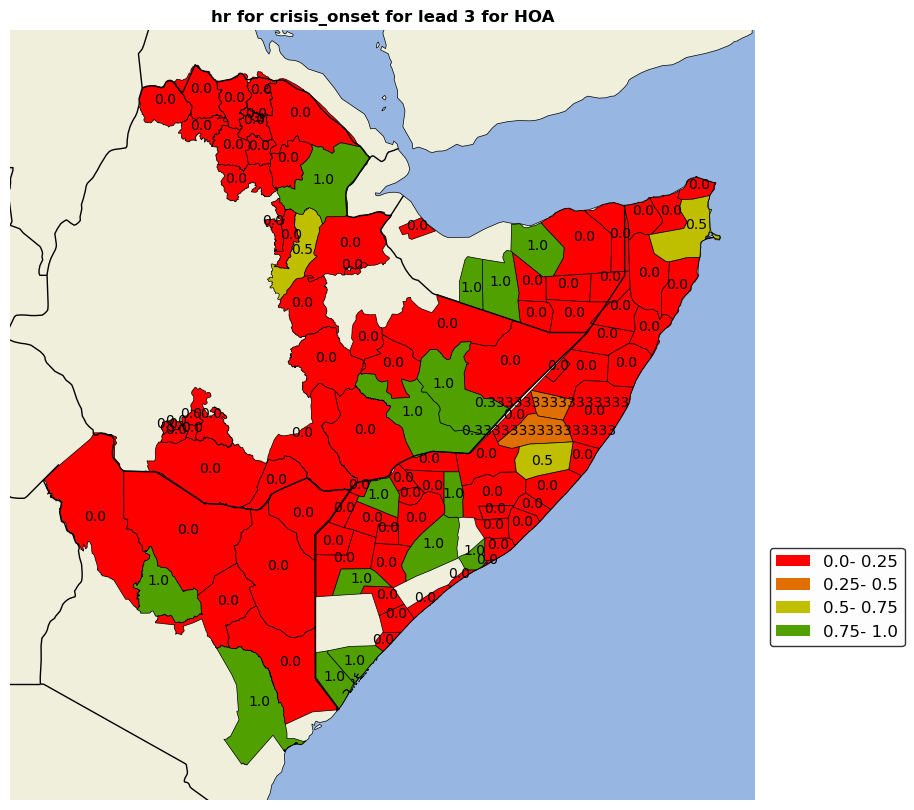

In [9]:
plot_var= 'hr' # can be normal eval stats or ending with '_fews' for the fews stats
lead=3

color1=Color("green")
color2=Color("red")

eval_stats_lead=eval_stats[eval_stats['lead']==lead]
# delete nan rows from eval_stats
if plot_var=='f1_score':
    eval_stats_lead=eval_stats_lead[eval_stats_lead['event_count']>=1]

if (plot_var=='hr')|(plot_var=='hr_fews')|(plot_var=='far')|(plot_var=='far_fews'):
    eval_stats_lead=eval_stats_lead[eval_stats_lead['event_count']>=1]
########### VERIFICATION MAPS ###############        #https://residentmario.github.io/geoplot/plot_references/plot_reference.html
eval_stats_lead['mae_ref']=eval_stats_lead['mae_baseline']-eval_stats_lead['mae'] # to show improvement compared to baseline

#eval_stats_lead['mae_%']= ((eval_stats_lead['mae']-eval_stats_lead['mae_baseline'])/(eval_stats_lead['mae_baseline']+0.01))*100 #Percentage Decrease = [(Original value – New value)/Original value] × 100
#for plot_var in ['mae', 'rmse', 'r2']:
#plot_var='mae_ref' # variable to plot
#for lead in eval_stats['lead'].unique():


if extent=='Kenya':
    county_sf=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Kenya/County.shp')
    county_sf.rename(columns={'COUNTY':'county'}, inplace=True)

if extent=='Ethiopia':
    county_sf=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Ethiopia/eth_admbnda_adm2_csa_bofedb_2021.shp')
    county_sf.rename(columns={'ADM2_EN':'county'}, inplace=True) 
if extent=='Somalia':
    county_sf=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/Somalia/Som_Admbnda_Adm2_UNDP.shp')
    county_sf.rename(columns={'admin2Name':'county'}, inplace=True) 

if extent=='HOA':
    county_sf=gpd.read_file(VECTOR_FOLDER+'geo_boundaries/HOA/HOA.shp')

#ax = gplt.polyplot(county_sf, projection=gcrs.AlbersEqualArea())
fig, ax = plt.subplots(1, 1,figsize=(12,10),subplot_kw={'projection': ccrs.PlateCarree()})
#print (len(county_sf.county.unique()))

# plot cartopy features --> https://stackoverflow.com/questions/67508054/improve-resolution-of-cartopy-map

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-',linewidth=1)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
#ax.add_feature(cartopy.feature.RIVERS)

plot_vals=eval_stats_lead[[plot_var, 'county']] 
county_sf=pd.merge(county_sf, plot_vals, on='county')
county_sf= county_sf[~county_sf[plot_var].isna()]
county_sf=county_sf[['geometry', plot_var]]






if (plot_var=='r2')|(plot_var=='r2_fews'):
    bin_edges=[0, 0.25, 0.5, 0.75,1]
if (plot_var=='mae')|(plot_var=='mae_fews'):
    bin_edges= list(np.round(np.arange(0.0,1.1,0.1),2))

if (plot_var=='f1_score')|(plot_var=='f1_score_fews'):
    bin_edges= list(np.round(np.arange(0.0,1.1,0.25),2))
    
if (plot_var=='hr')|(plot_var=='hr_fews')|(plot_var=='far')|(plot_var=='far_fews'):
    bin_edges= list(np.round(np.arange(0.0,1.1,0.25),2))


# attach class to class column on county_sf with loop. Base on bin_edges
for i in range(len(bin_edges)):
    #if i==0:
    # first class
    #county_sf.loc[county_sf[plot_var]<=bin_edges[0], 'class']= '<%s'%(bin_edges[0])
    #else:
    # other classes
    county_sf.loc[(county_sf[plot_var]>=bin_edges[i-1]) & (county_sf[plot_var]<=bin_edges[i]), 'class']= '%s- %s'%(bin_edges[i-1],bin_edges[i])
    
    county_sf.loc[county_sf[plot_var]>bin_edges[-1], 'class']= '>%s'%(bin_edges[-1])
    
county_sf=county_sf.sort_values(by='class')

if len(county_sf[county_sf['class'].isna()])>0:
    print(county_sf[county_sf['class'].isna()])

if plot_var=='mae' or plot_var=='mae_fews':
    colors = list(color1.range_to(color2,len(bin_edges)))
    hepex_list= [color.hex for color in colors]

    color_dict = dict(zip(county_sf['class'].unique(), hepex_list))  

    color_dict = {key: color_dict[key]
                 for key in color_dict if key not in  list(set(color_dict)-set(county_sf['class'].unique()))
                 }
else:
    #desired color dict
    color_dict={'0.0- 0.25': '#f00',
     '0.25- 0.5': '#df7000',
     '0.5- 0.75': '#bfbf00',
     '0.75- 1.0': '#50a000'}

#map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))
county_sf['colour'] = county_sf['class'].apply(lambda x: color_dict[x])

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)  

# and plot the map
county_sf.plot(color=county_sf['colour'],ax=ax,linewidth=0.5, edgecolor='black')

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))        

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2)) 

# labels 

# Calculate the centroid for each county
county_sf['coords'] = county_sf['geometry'].apply(lambda x: x.representative_point().coords[:])
county_sf['coords'] = [coords[0] for coords in county_sf['coords']]

# Annotate the plot with the values
for idx, row in county_sf.iterrows():
    ax.annotate(text=str(row[plot_var]), xy=row['coords'], xytext=(0, 0), textcoords="offset points", ha='center')
# add a title
ax.set_title('%s for %s for lead %s for %s'%(plot_var, method,lead, extent),fontweight='bold')
plt.savefig(paper_plots+'verif_map_lead_%s_%s_%s_%s.pdf'%(lead,extent,plot_var,experiment), dpi=300, bbox_inches='tight')
plt.show()


DASHBOARD TIMESERIES 

FixedFormatter should only be used together with FixedLocator


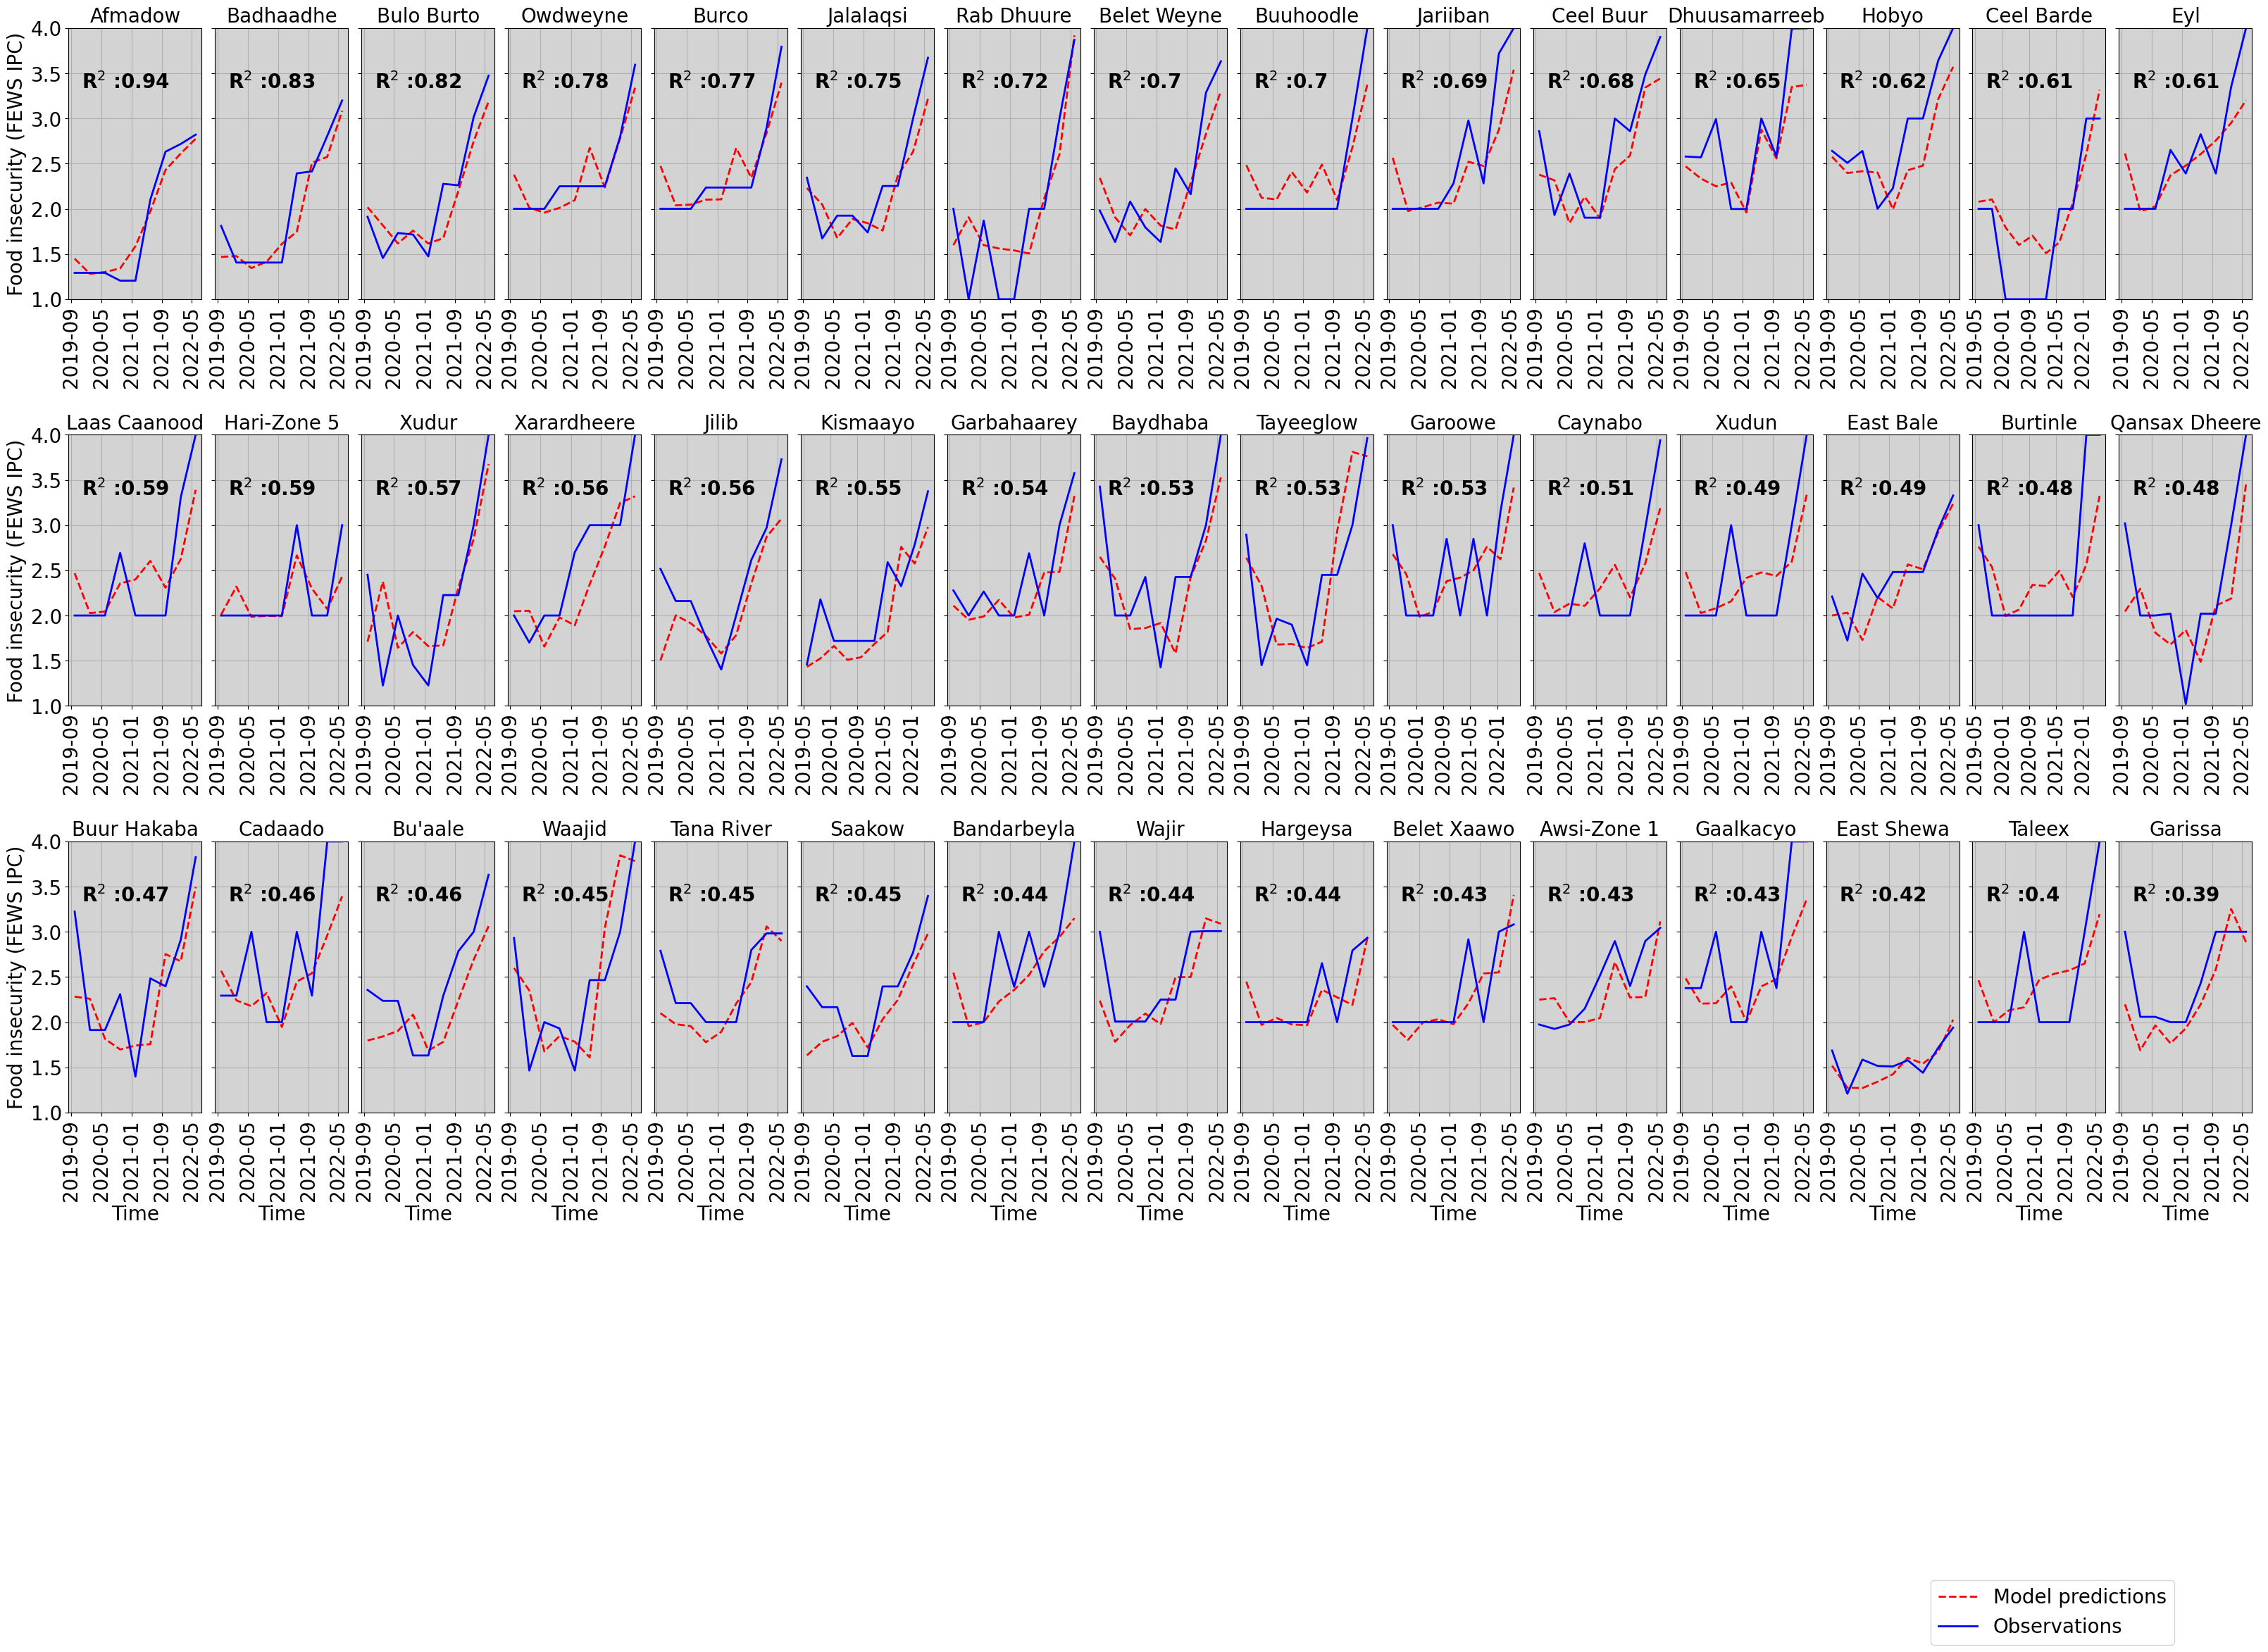

In [10]:
lead=3
eval_var='r2'
plot_df=preds_storage_master[preds_storage_master['lead']==lead]
#plot_df=plot_df[plot_df['cluster']=='other']
counties=plot_df.county.unique()
plot_by='eval' # 'eval' or 'variance'



################################## variance per county ##################################
variances=[]
for county in counties:
    county_df=plot_df[plot_df['county']==county]
    variances.append(county_df.observed.var())

counties_df=pd.DataFrame({'county':counties,'variance':variances})

counties_df=counties_df.reset_index(drop=True)


################################### eval per county #####################################

evals=[]
for county in counties:
    county_df=eval_stats[eval_stats['county']==county]
    county_df=county_df[county_df['lead']==lead]
    evals.append(county_df[eval_var].mean())

counties_df=pd.DataFrame({'county':counties,'eval':evals, 'variance':variances})



################################### plot by eval or variance #####################################



if plot_by=='variance':
    counties_df=counties_df[['county', 'variance']]
    eval_sorted=counties_df.sort_values(by='variance',ascending=False)
    counties_plot=eval_sorted.head(45).county.values
if plot_by=='eval':
    counties_df=counties_df[['county', 'eval']]
    eval_sorted=counties_df.sort_values(by='eval',ascending=False)
    counties_plot=eval_sorted.head(45).county.values


################################### plot section #####################################
fig=plt.figure(figsize=(40,20))# (W,H)
gs=fig.add_gridspec(3,15,wspace=0.1,hspace=0.5)

indexer=0
for i in range(gs.nrows):
    for j in range(gs.ncols):
        
        # select county data
        county=counties_plot[indexer]
        #print (county)
        ax=fig.add_subplot(gs[i,j])


        county_df=plot_df[plot_df['county']==county]

        #plot details 
        ax.plot(county_df.prediction,label='Model predictions',color='red',linestyle='--',linewidth=2)
        #ax.plot(county_df.base1_preds,label='Baseline predictions',color='green',linestyle='--',linewidth=4)
        #ax.plot(county_df.base2_preds,label='Baseline2 predictions',color='orange',linestyle='--',linewidth=4)
        
        ax.plot(county_df.observed,label='Observations',color='blue',linestyle='-',linewidth=2)
        ax.set_title(county,size=20)
        ax.set_xlabel('Time',size=20)
        ax.set_ylabel('Food insecurity (FEWS IPC)',size=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.grid()

        # extract the county mae from the eval_stats df
        county_eval=eval_stats[eval_stats['county']==county]
        county_eval=county_eval[county_eval['lead']==lead]
        # Make a R2 string (squared) I want the square to be a superscript
        ax.text(0.1, 0.8, 'R$^2$ :'+str(round(county_eval[eval_var].values[0],2)), horizontalalignment='left',verticalalignment='center', fontweight='bold', transform=ax.transAxes,fontsize=20)
        # mae_baseline 
        eval_value=county_eval[eval_var+'_baseline'].values[0]
        eval_value=round(eval_value,2)
        #ax.text(0.1, 0.92, 'R$^2$ persistence: '+str(eval_value), horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
        # mae_baseline2
        county_eval=eval_stats[eval_stats['county']==county][eval_var+'_baseline2'].values[0]
        county_eval=round(county_eval,2)
        #ax.text(0.1, 0.89, 'R$^2$ seasonality: '+str(county_eval), horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)

        # rotate x axis labels 90 degrees
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
        ax.set_ylim([1, 4])

        ax.set_facecolor('lightgrey')

        # Get current x-ticks and labels
        xticks = ax.get_xticks()
        xticklabels = ax.get_xticklabels()

        # Set new x-ticks and labels to be every other one
        ax.set_xticks(xticks[::2])  # Change this to control the frequency
        ax.set_xticklabels(xticklabels[::2], rotation=90, fontsize=20)


        

        indexer+=1

list_of_numbers=list(range(0,45))
list_of_numbers.remove(0)
list_of_numbers.remove(15)
list_of_numbers.remove(30)

for i in list_of_numbers:
    fig.axes[i].yaxis.set_visible(True)
    fig.axes[i].yaxis.set_ticklabels([])
    fig.axes[i].set_ylabel('')


# I want to delete axis labels and ticks of the x-axis for all but the bottom row
for i in range(0,30):
    fig.axes[i].xaxis.set_visible(True)
    #fig.axes[i].xaxis.set_ticklabels([])
    fig.axes[i].set_xlabel('')


plt.legend(loc='lower center', bbox_to_anchor=(-0.5, -2),ncol=1,fontsize=20)
plt.savefig(paper_plots+'timeseries.pdf',bbox_inches='tight')
plt.show()





Lead time graphs 

In [11]:
######################################### calculate evaluation metrics over the countries or lhz #################################
preds_storage_plot=preds_storage_master.copy()

total_df=pd.DataFrame()

# aggregation for evaluation plot 

units=preds_storage_plot.cluster.unique() # country or cluster
unit_level= 'cluster' # 'country' or 'cluster'

for unit in units:
    units_data= preds_storage_plot[preds_storage_plot[unit_level]==unit]
    
    for lead in preds_storage_plot.lead.unique(): 
        data_lead= units_data[units_data['lead']==lead]
        
        # R2 
        r2= r2_score(data_lead['observed'], data_lead['prediction'])
        r2_baseline= r2_score(data_lead['observed'], data_lead['base1_preds'])
        r2_baseline2= r2_score(data_lead['observed'], data_lead['base2_preds'])

        # MAE
        mae= mean_absolute_error(data_lead['observed'], data_lead['prediction'])
        mae_baseline= mean_absolute_error(data_lead['observed'], data_lead['base1_preds'])
        mae_baseline2= mean_absolute_error(data_lead['observed'], data_lead['base2_preds'])

        # HR and FAR
        
        # ML preds
        co, co_pred,event_count,h,fa,ms,cn,hr,far,recall,precision,f1= cont_calc(data_lead['observed'],data_lead['prediction'],method, threshold, co_buffer)    
        hr_ML=hr.copy()
        far_ML=far.copy()
        
        # base1_preds
        co,co_pred,event_count,h,fa,ms,cn,hr,far,recall,precision,f1= cont_calc(data_lead['observed'],data_lead['base1_preds'],method, threshold, co_buffer)
        hr_baseline=hr.copy()
        far_baseline=far.copy()
        
        # base2 preds
        co,co_pred,event_count,h,fa,ms,cn,hr,far,recall,precision,f1= cont_calc(data_lead['observed'],data_lead['base2_preds'],method, threshold, co_buffer)
        hr_baseline2=hr.copy()
        far_baseline2=far.copy()
        
        # FEWS scores 
        if (lead==0 or lead==12): # these leads do not exist for FEWS 
            r2_fews= np.nan
            mae_fews=np.nan
            hr_fews=np.nan
            far_fews=np.nan
        
        else: 
            truth_FSO=data_lead['OBS_FSO'][~np.isnan(data_lead['OBS_FSO'])]            
            fews_preds= data_lead['FEWS_prediction'][~np.isnan(data_lead['FEWS_prediction'])]
            
            r2_fews=r2_score(truth_FSO,fews_preds) 
            mae_fews= mean_absolute_error(truth_FSO,fews_preds)
            
            co_fews,co_pred_fews,event_count_fews, h_fews, fa_fews, ms_fews, cn_fews, hr_fews, far_fews, recall_fews, precision_fews, f1_fews = cont_calc(truth_FSO,fews_preds,method, threshold, co_buffer)
                
                
        # concat to df
        total_df=pd.concat([total_df, pd.DataFrame({'unit':unit, 'event_count':event_count,'lead':lead, 'r2':r2, 'r2_baseline':r2_baseline, 'r2_baseline2':r2_baseline2, 'mae':mae, 'mae_baseline':mae_baseline, 'mae_baseline2':mae_baseline2, 'hr':hr_ML, 'hr_baseline':hr_baseline, 'hr_baseline2':hr_baseline2, 'far':far_ML, 'far_baseline':far_baseline, 'far_baseline2':far_baseline2, 'hr_fews': hr_fews, 'far_fews':far_fews, 'r2_fews':r2_fews, 'mae_fews':mae_fews}, index=[0])])
        #print(total_df)


In [12]:
print(len(preds_storage_master[preds_storage_master['cluster']=='ap'].county.unique()))
print(len(preds_storage_master[preds_storage_master['cluster']=='p'].county.unique()))
print(len(preds_storage_master[preds_storage_master['cluster']=='other'].county.unique()))
print(units_data[units_data['lead']==12].tail(50))

25
82
106
            observed  prediction  base1_preds  base2_preds  lead     county  \
date                                                                          
2021-02-01  2.000000    1.810949     2.000000     1.500000    12    Banadir   
2021-06-01  2.000000    2.110307     2.000000     2.000000    12    Banadir   
2021-10-01  2.000000    1.729464     2.000000     2.700000    12    Banadir   
2022-02-01  2.000000    1.760083     2.000000     1.500000    12    Banadir   
2022-06-01  3.000000    2.436963     2.000000     2.000000    12    Banadir   
2019-10-01  3.000000    2.215552     2.721589     2.559691    12    Jamaame   
2020-02-01  2.721589    2.135398     2.000000     1.872687    12    Jamaame   
2020-06-01  2.721589    1.972273     1.000000     2.250000    12    Jamaame   
2020-10-01  2.721589    1.904840     2.000000     2.559691    12    Jamaame   
2021-02-01  2.715765    2.174335     3.000000     1.872687    12    Jamaame   
2021-06-01  2.994176    2.453114     2.721

Lead time overview plot 

Paper lead time plots 

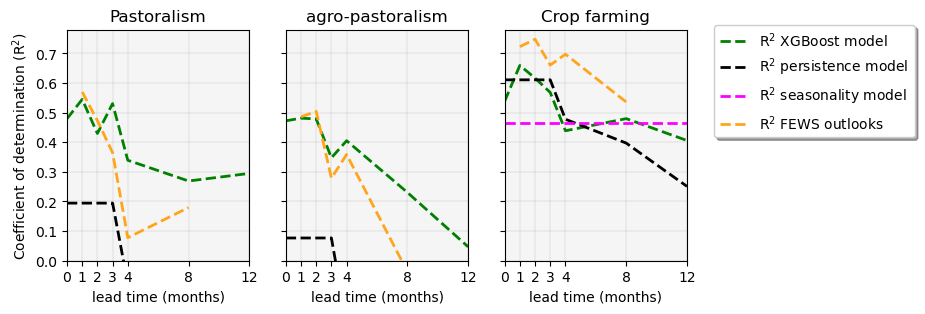

In [13]:

############################################# PAPER R2 PLOT  ########################################################
fig, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)

# Area 1 
data_1= total_df[total_df['unit']=='p']  # Kenya or p

# R2
ax[0].plot(data_1['lead'], data_1['r2'], label='r2', color='green', linewidth=2, linestyle='--')
ax[0].plot(data_1['lead'], data_1['r2_baseline'], label='r2 baseline', color='black', linewidth=2, linestyle='--')
ax[0].plot(data_1['lead'], data_1['r2_baseline2'], label='r2 baseline2', color='magenta', linewidth=2, linestyle='--')
ax[0].plot(data_1['lead'], data_1['r2_fews'], label='r2 fews fso', color='#FFA51B', linewidth=2, linestyle='--')

ax[0].set_title('Pastoralism')
ax[0].set_ylabel('Coefficient of determination (R$^2$)')
ax[0].set_xlabel('lead time (months)')


# Area 2  
data_2= total_df[total_df['unit']=='ap'] # Ethiopia or ap

# R2
ax[1].plot(data_2['lead'], data_2['r2'], label='r2', color='green', linewidth=2, linestyle='--')
ax[1].plot(data_2['lead'], data_2['r2_baseline'], label='r2 baseline', color='black', linewidth=2, linestyle='--')
ax[1].plot(data_2['lead'], data_2['r2_baseline2'], label='r2 baseline2', color='magenta', linewidth=2, linestyle='--')
ax[1].plot(data_2['lead'], data_2['r2_fews'], label='r2 fews fso', color='#FFA51B', linewidth=2, linestyle='--')

ax[1].set_title('agro-pastoralism')
#ax[1].set_ylabel('Coefficient of determination (R$^2$)')
ax[1].set_xlabel('lead time (months)')

# Area 3 
data_3= total_df[total_df['unit']=='other'] # Somalia or other 

# R2
ax[2].plot(data_3['lead'], data_3['r2'], label='R$^2$ XGBoost model', color='green', linewidth=2, linestyle='--')
ax[2].plot(data_3['lead'], data_3['r2_baseline'], label='R$^2$ persistence model ', color='black', linewidth=2, linestyle='--')
ax[2].plot(data_3['lead'], data_3['r2_baseline2'], label='R$^2$ seasonality model', color='magenta', linewidth=2, linestyle='--')
ax[2].plot(data_3['lead'], data_3['r2_fews'], label='R$^2$ FEWS outlooks', color='#FFA51B', linewidth=2, linestyle='--')

ax[2].set_title('Crop farming')
#ax[2].set_ylabel('Coefficient of determination (R$^2$)')
ax[2].set_xlabel('lead time (months)')


plt.ylim(0,0.78)
plt.xlim(0,12)
# x ticks 0,1,2,3,4,8,12
plt.xticks([0,1,2,3,4,8,12])

# gridlines and background color 
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax[2].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

ax[0].set_facecolor('whitesmoke') 
ax[1].set_facecolor('whitesmoke')
ax[2].set_facecolor('whitesmoke')


#fig.suptitle('R2 score for different lead times', fontsize=16)
# legend outside of plot 
plt.legend(loc='upper center', bbox_to_anchor=(1.7, 1.05), ncol=1, fancybox=True, shadow=True)

plt.savefig(paper_plots+'R2_timeline.pdf',bbox_inches='tight')

plt.show()

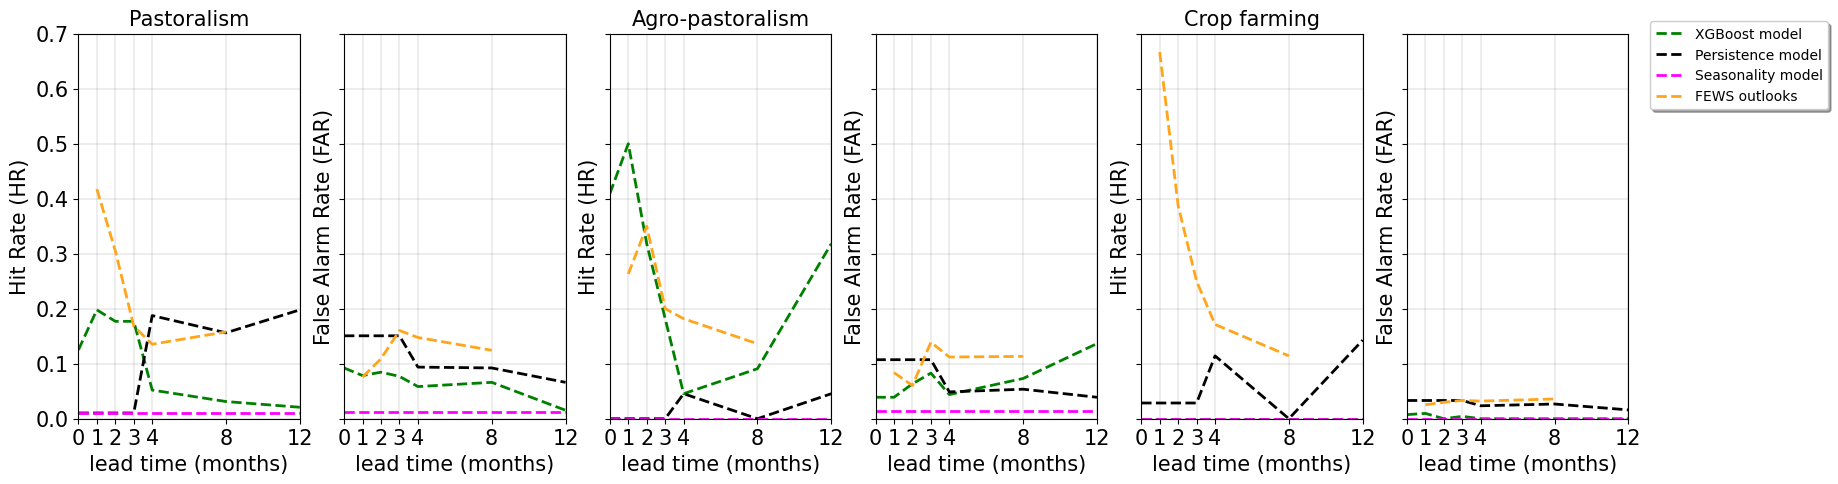

In [14]:
############################################# PLOT Paper HR-FAR ########################################################

fig, ax = plt.subplots(1,6, figsize=(20,5), sharex=True, sharey=True)
line_width_var= 2


# Area 1 --> pastoralists 
data_1= total_df[total_df['unit']=='p']  # Kenya or p 


# HR
ax[0].plot(data_1['lead'], data_1['hr'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[0].plot(data_1['lead'], data_1['hr_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[0].plot(data_1['lead'], data_1['hr_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[0].plot(data_1['lead'], data_1['hr_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')

ax[0].set_title('Pastoralism', fontsize=15)
ax[0].set_ylabel('Hit Rate (HR)', fontsize=15)
ax[0].set_xlabel('lead time (months)', fontsize=15)

# FAR
ax[1].plot(data_1['lead'], data_1['far'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[1].plot(data_1['lead'], data_1['far_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[1].plot(data_1['lead'], data_1['far_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[1].plot(data_1['lead'], data_1['far_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')


ax[1].set_ylabel('False Alarm Rate (FAR)', fontsize=15)
ax[1].set_xlabel('lead time (months)', fontsize=15)


# Area 2 --> agropastoralists
data_2= total_df[total_df['unit']=='ap'] # Ethiopia or ap 

# HR
ax[2].plot(data_2['lead'], data_2['hr'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[2].plot(data_2['lead'], data_2['hr_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[2].plot(data_2['lead'], data_2['hr_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[2].plot(data_2['lead'], data_2['hr_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')


ax[2].set_title('Agro-pastoralism', fontsize=15)
ax[2].set_ylabel('Hit Rate (HR)', fontsize=15)
ax[2].set_xlabel('lead time (months)', fontsize=15)

# FAR
ax[3].plot(data_2['lead'], data_2['far'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[3].plot(data_2['lead'], data_2['far_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[3].plot(data_2['lead'], data_2['far_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[3].plot(data_2['lead'], data_2['far_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')

ax[3].set_ylabel('False Alarm Rate (FAR)', fontsize=15)
ax[3].set_xlabel('lead time (months)', fontsize=15)

# Area 3 --> other (crop farming)
data_3= total_df[total_df['unit']=='other'] # Somalia or other

#HR
ax[4].plot(data_3['lead'], data_3['hr'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[4].plot(data_3['lead'], data_3['hr_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[4].plot(data_3['lead'], data_3['hr_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[4].plot(data_3['lead'], data_3['hr_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')


ax[4].set_title('Crop farming', fontsize=15)
ax[4].set_ylabel('Hit Rate (HR)', fontsize=15)
ax[4].set_xlabel('lead time (months)', fontsize=15)

# FAR
ax[5].plot(data_3['lead'], data_3['far'], label='XGBoost model', color='green', linewidth=line_width_var, linestyle='--')
ax[5].plot(data_3['lead'], data_3['far_baseline'], label='Persistence model', color='black', linewidth=line_width_var, linestyle='--')
ax[5].plot(data_3['lead'], data_3['far_baseline2'], label='Seasonality model', color='magenta', linewidth=line_width_var, linestyle='--')
ax[5].plot(data_3['lead'], data_3['far_fews'], label='FEWS outlooks', color='#FFA51B', linewidth=line_width_var, linestyle='--')


ax[5].set_ylabel('False Alarm Rate (FAR)', fontsize=15)
ax[5].set_xlabel('lead time (months)', fontsize=15)


plt.ylim(0,0.7)
plt.xlim(0,12)
plt.xticks([0,1,2,3,4,8,12])


# size of tick labels
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[3].tick_params(axis='both', which='major', labelsize=15)
ax[4].tick_params(axis='both', which='major', labelsize=15)
ax[5].tick_params(axis='both', which='major', labelsize=15)


# gridlines and background color 
ax[0].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)
ax[1].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)
ax[2].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)
ax[3].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)
ax[4].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)
ax[5].grid(color='black', linestyle='-', linewidth=0.25, alpha=0.4)

# ax[0].set_facecolor('whitesmoke') 
# ax[1].set_facecolor('whitesmoke')
# ax[2].set_facecolor('whitesmoke')
# ax[3].set_facecolor('whitesmoke')
# ax[4].set_facecolor('whitesmoke')
# ax[5].set_facecolor('whitesmoke')

#fig.suptitle('R2 score for different lead times', fontsize=16)
# legend outside of plot 
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05), ncol=1, fancybox=True, shadow=True)

plt.savefig(paper_plots+'HR_timeline.pdf',bbox_inches='tight')

plt.show()


color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


12 0.6558385914226945
12 0.717565721777685


color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


12 0.6743064808912924
12 0.6675976229453795


color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


12 0.5793412867200844
12 0.5623383581676669


color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


12 0.5237407356570892


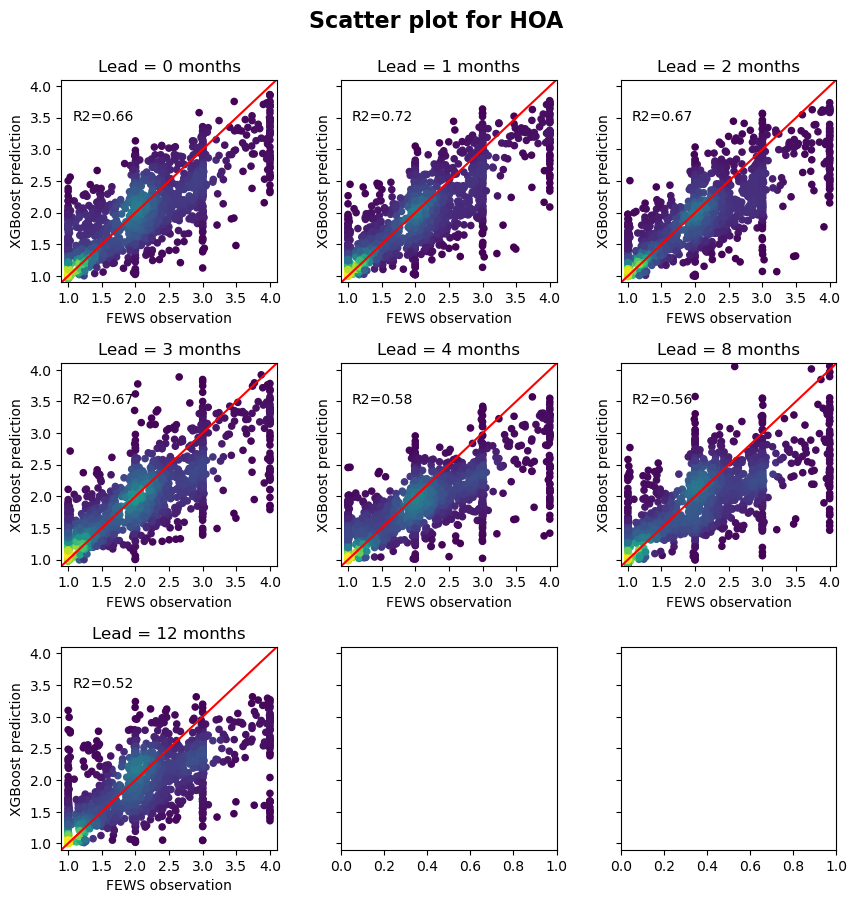

In [15]:
country= 'HOA' # country to plot
plot_cluster= None # None or cluster_list
cluster= None
pred_type='prediction' # base1_preds or prediction or FEWS_prediction
obs_type='observed'# OBS_FSO or observed 
if country!= 'HOA':
    preds_storage_plot= preds_storage_master[preds_storage_master['country']==country]

else: 
    preds_storage_plot= preds_storage_master.copy()


if plot_cluster!=None: 
    preds_storage_plot=preds_storage_plot[preds_storage_plot['cluster']==cluster]

preds_storage_plot=preds_storage_plot[~np.isnan(preds_storage_plot[pred_type])]

fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey=True, sharex=False,gridspec_kw={'hspace': 0.4, 'wspace': 0.3, 'width_ratios': [1, 1, 1], 'height_ratios': [1, 1, 1]})
fig.suptitle('Scatter plot for %s'%(country), fontsize=16, fontweight='bold', y=0.95)

for i in range(len(preds_storage_plot.lead.unique())):
    
    max_fews= int(round(preds_storage_plot[obs_type].max(),0))
    min_fews= int(round(preds_storage_plot[obs_type].min(),0))
    margin=0.1
    
    preds_lead=preds_storage_plot[preds_storage_plot['lead']==preds_storage_plot.lead.unique()[i]]
    preds_lead= preds_lead[~np.isnan(preds_lead[pred_type])]
    

    values = np.vstack([preds_lead[obs_type], preds_lead[pred_type]])
    kernel = stats.gaussian_kde(values)(values) #Representation of a kernel-density estimate using Gaussian kernels.

    # 1:1 line 
    axs[i//3, i%3].plot([min_fews-margin, max_fews+margin], [min_fews-margin, max_fews+margin], 'k-', color = 'r')

    # scatter 
    axs[i//3, i%3].scatter(preds_lead[obs_type].values, preds_lead[pred_type].values, c=kernel,cmap="viridis", label='L=%s'%(preds_lead.lead.unique()[0]), s=20)


    # format plot
    axs[i//3, i%3].set_title('Lead = %s months'%(preds_lead.lead.unique()[0]))

    # add R2 as text to plot
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(preds_lead[pred_type].values, preds_lead[obs_type].values)
    coef_determination = r2_score(preds_lead[obs_type].values, preds_lead[pred_type].values)
    print (lead, coef_determination)
    r_squared=r_value**2
    axs[i//3, i%3].text(.05, .8, 'R2={:.2f}'.format(coef_determination),
            transform=axs[i//3, i%3].transAxes)





    axs[i//3, i%3].set_ylim(min_fews-margin,max_fews+margin)
    axs[i//3, i%3].set_xlim(min_fews-margin, max_fews+margin)

    axs[i//3, i%3].set_xlabel('FEWS observation')

    axs[i//3, i%3].set_ylabel('XGBoost prediction')
    # convert x tick labels to 0.5 interval 
    axs[i//3, i%3].set_xticks(np.arange(min_fews, max_fews+0.5, 0.5))
    

plt.savefig(paper_plots+'scatter_plot.pdf',bbox_inches='tight')

plt.show()



SHAP PLOTS 

In [16]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html 
shap_base_master= pd.DataFrame() 
shap_values_master= pd.DataFrame()
shap_data_master= pd.DataFrame()

for cluster in cluster_list: 
    shap_base= pd.read_excel(BASE+'shap_base_values_%s_%s_%s_%s.xlsx'%(aggregation,experiment,region_list[0],cluster), index_col=0)
    shap_values= pd.read_excel(BASE+'shap_values_%s_%s_%s_%s.xlsx'%(aggregation,experiment,region_list[0],cluster), index_col=0)
    shap_data= pd.read_excel(BASE+'shap_data_%s_%s_%s_%s.xlsx'%(aggregation,experiment,region_list[0],cluster), index_col=0)
    

    shap_base_master= pd.concat([shap_base_master, shap_base], axis=0)
    shap_values_master= pd.concat([shap_values_master, shap_values], axis=0)
    shap_data_master= pd.concat([shap_data_master, shap_data], axis=0)


Ranking


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


49


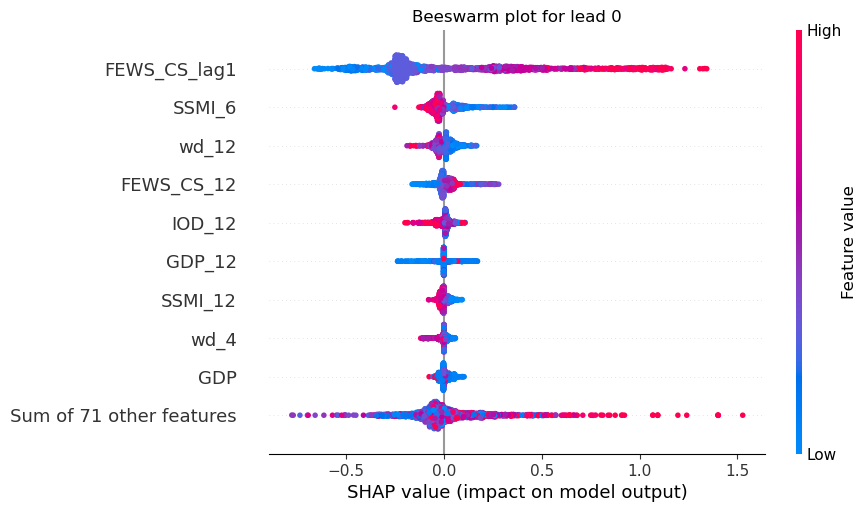

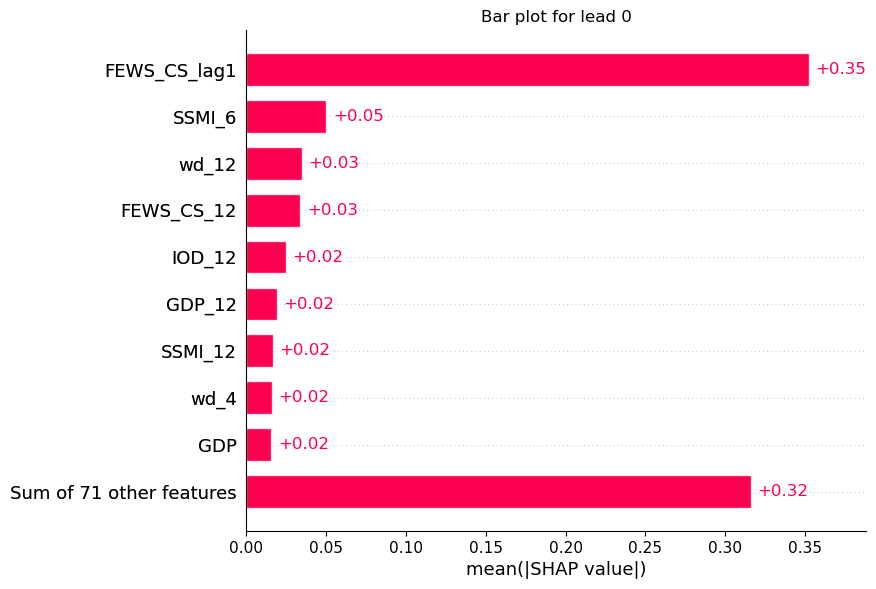


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


63


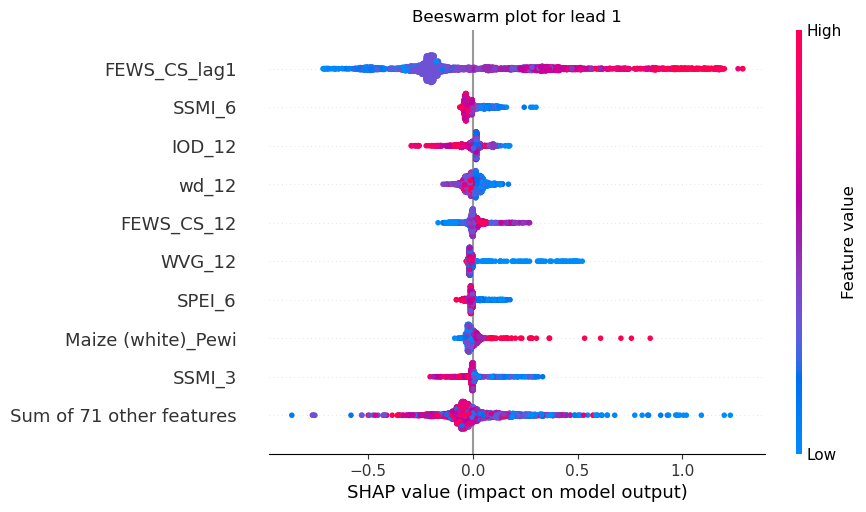

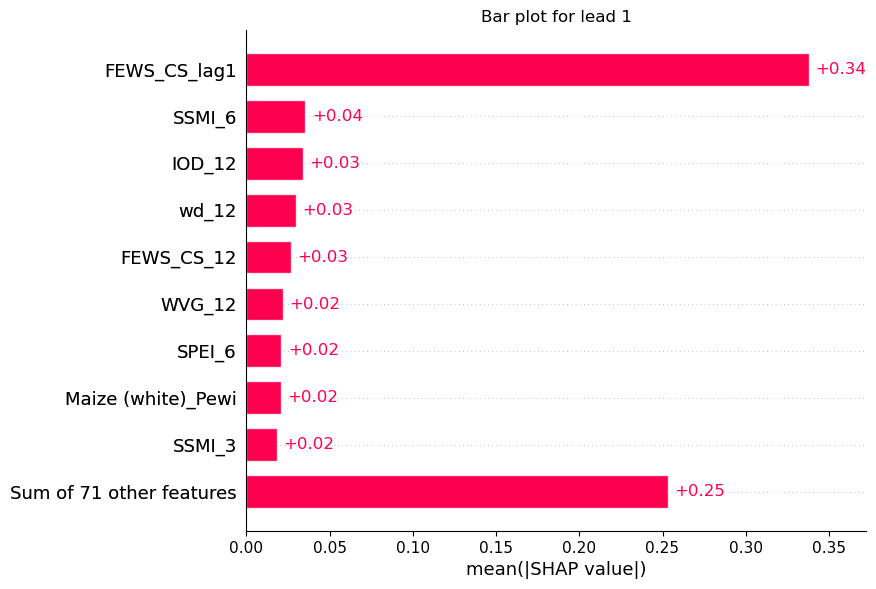


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


49


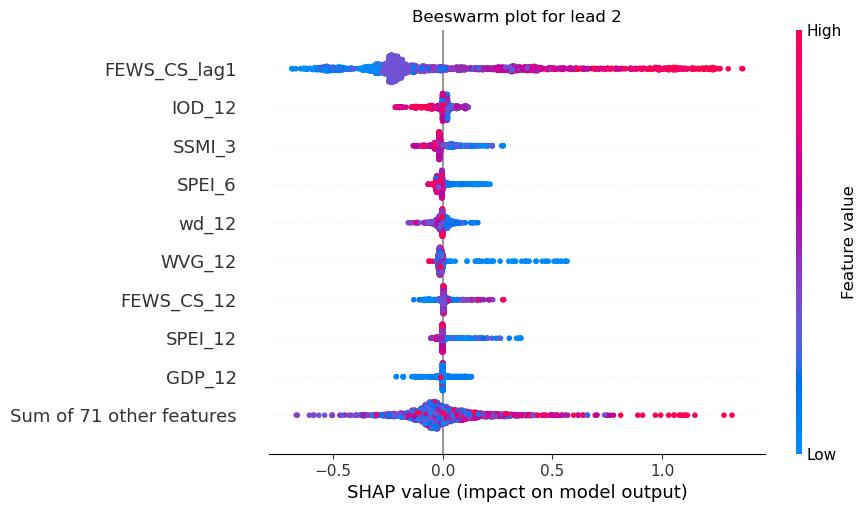

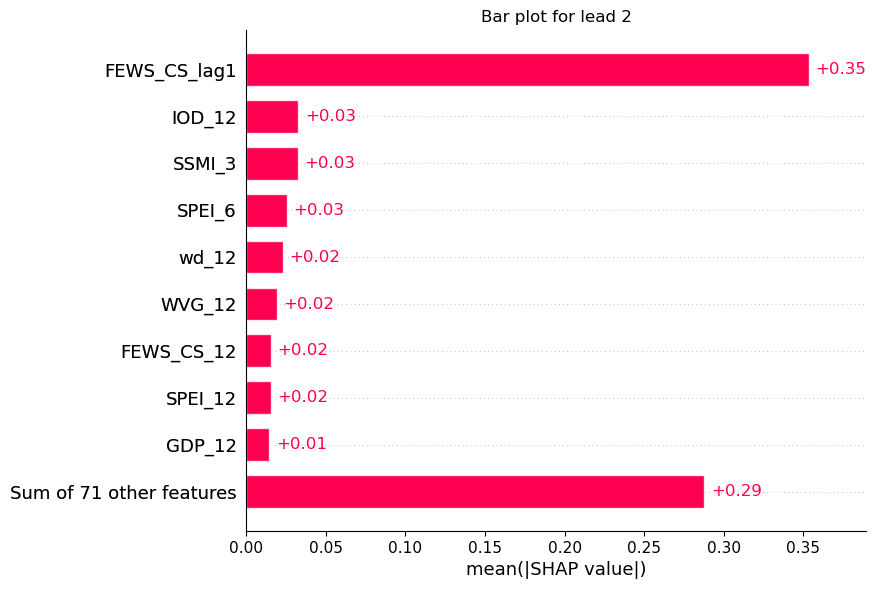


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


54


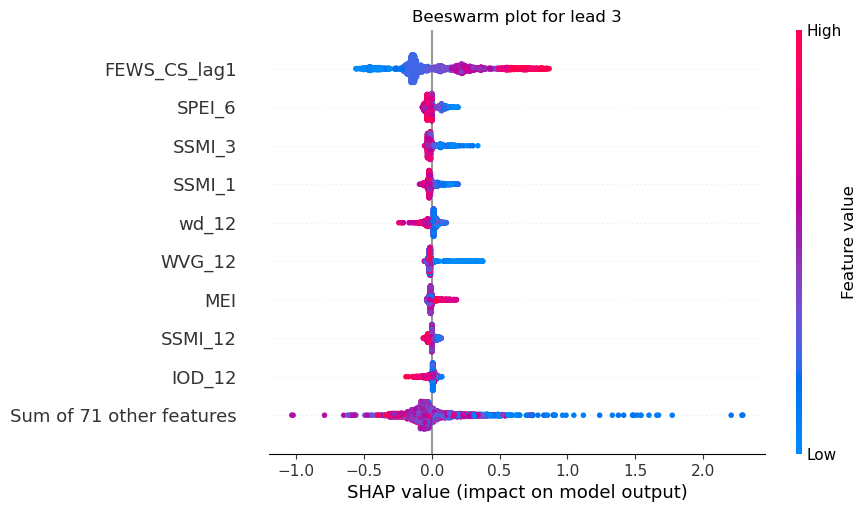

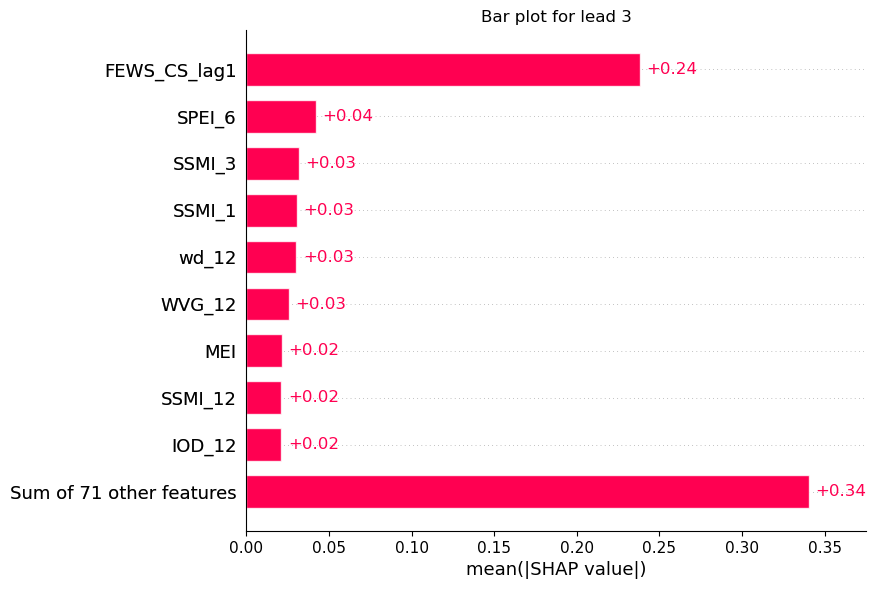


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


39


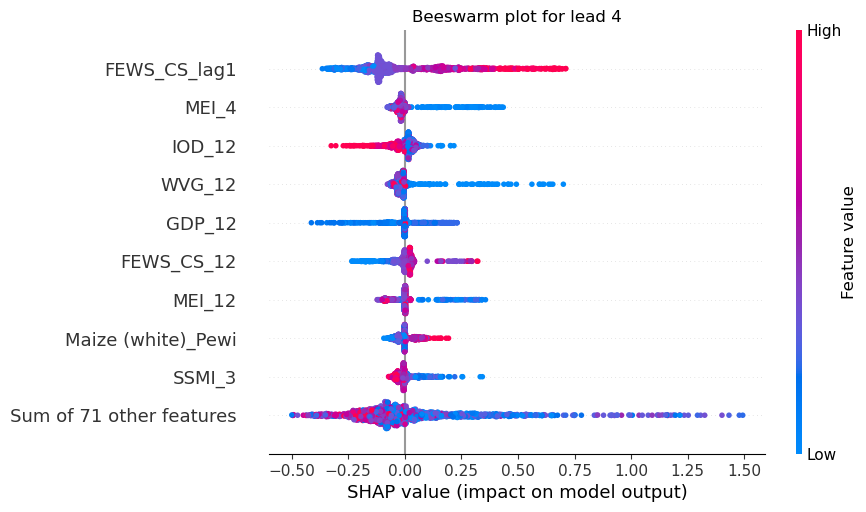

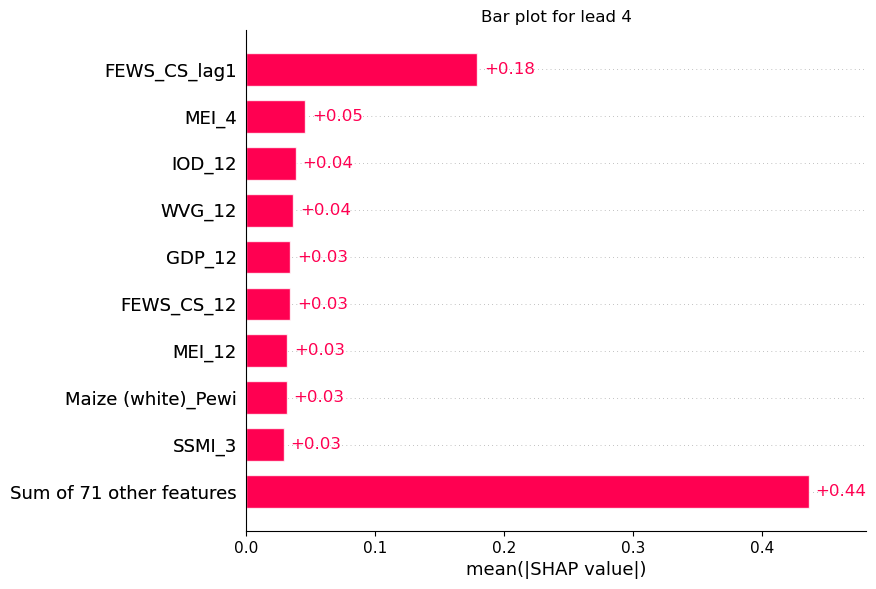


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


25


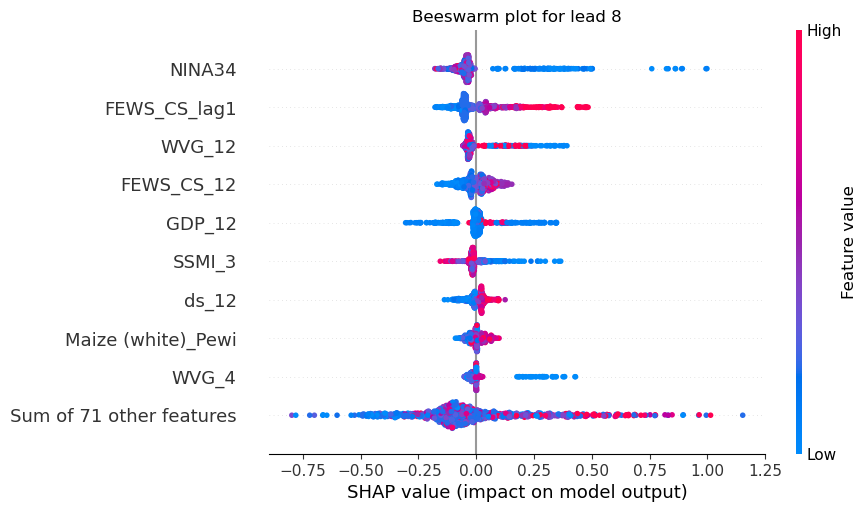

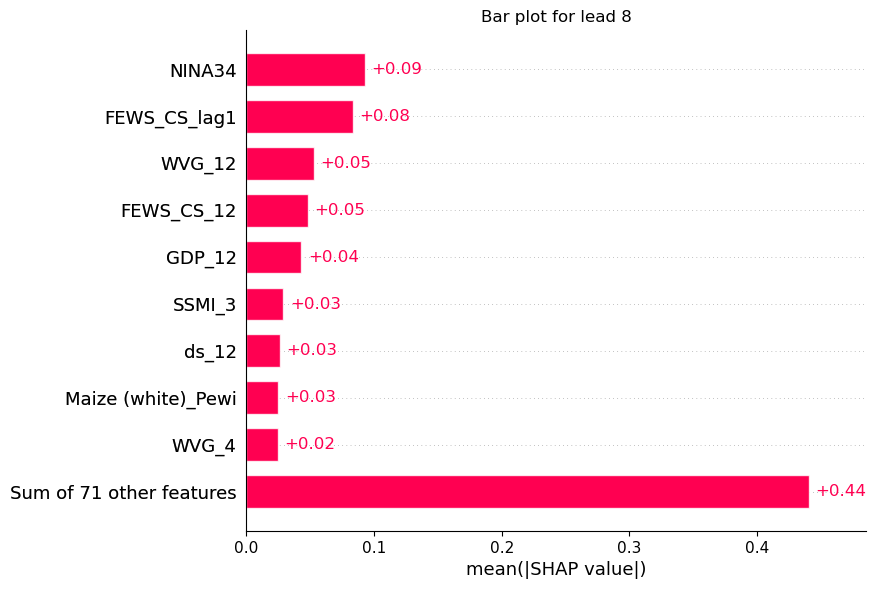


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


25


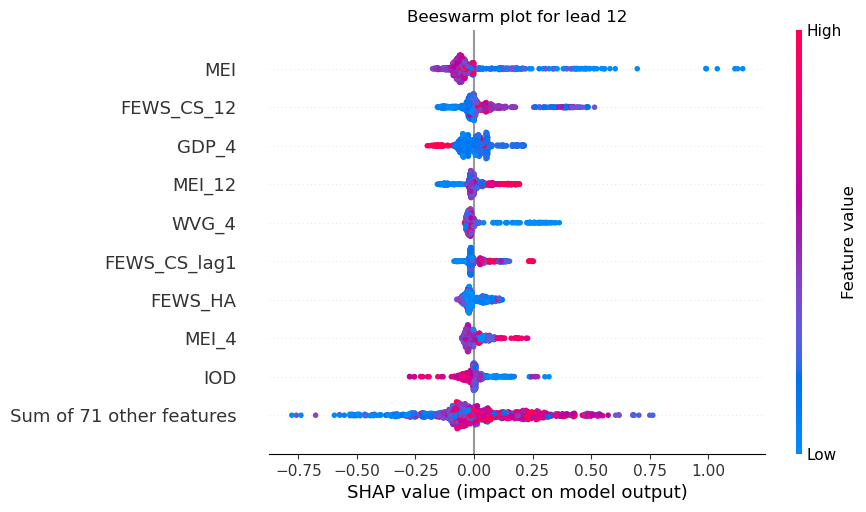

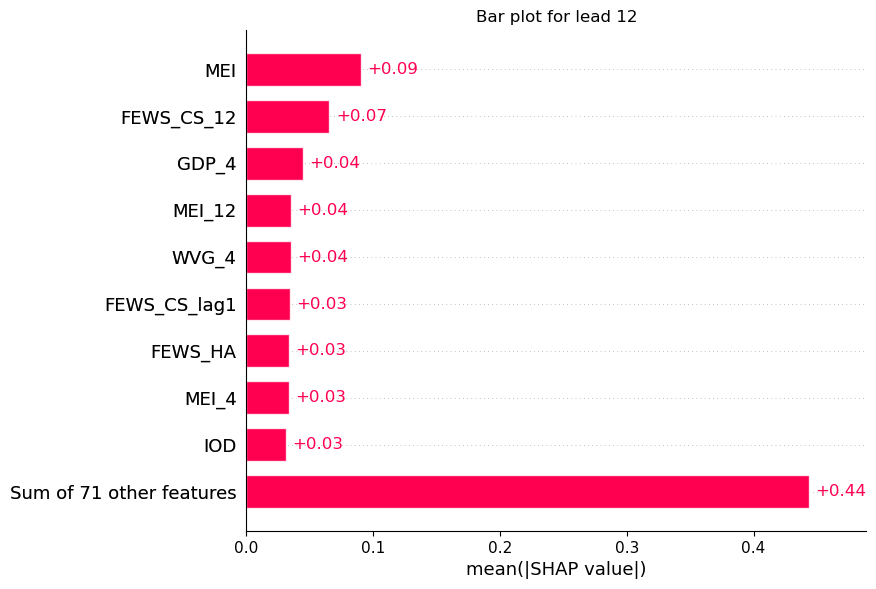

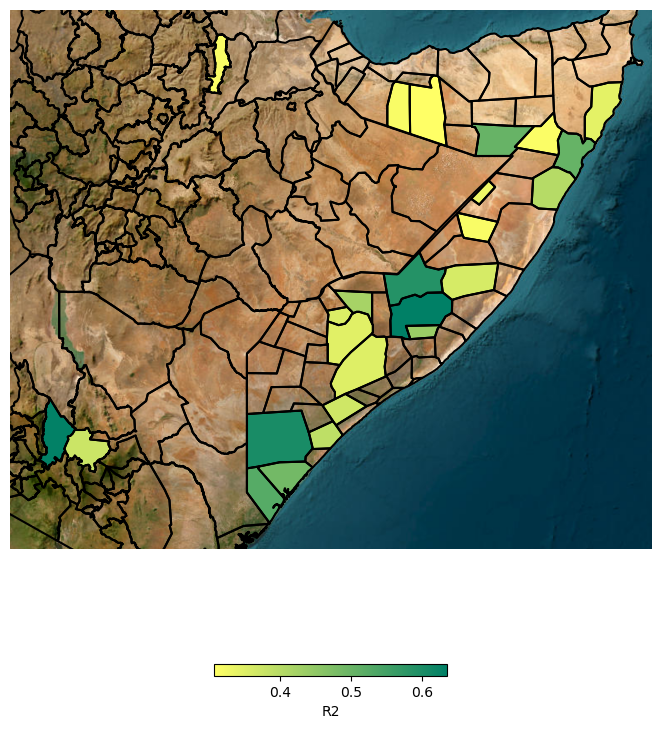

In [17]:
# write code to select best performing counties # 
# EXECUTE ABOVE BLOCK OF CODE ON THE CORRECT LEAD TIME WHEN MAKING THESE PLOTS! 
seperation_type= 'all' # cluster, country or county  or all
cluster='all' # cluster or all 
country='all' # country or all
eval_var='r2' # to filter counties 
leads=[0,1,2,3,4,8,12]
eval_threshold=0.3 # R2 threshold to filter counties
lead_for_plot= 8 # lead for spatial plot 
#counties_plot=[i for i in shap_base_master['county'].unique() if 'Tigray' in i] 

#print(counties_plot)
#leads=[0]
filter_on_best=True


for lead in leads:
    
    ################################### COUNTY FILTER #####################################
    plot_df=preds_storage_master[preds_storage_master['lead']==lead]
    counties=plot_df.county.unique()

    ################################### eval per county #####################################

    evals=[]
    for county in counties:
        county_df=eval_stats[eval_stats['county']==county]
        county_df=county_df[county_df['lead']==lead]
        evals.append(county_df[eval_var].mean())

    counties_df=pd.DataFrame({'county':counties,'eval':evals, 'variance':variances})



    ################################### plot by eval or variance #####################################
    counties_df=counties_df[['county', 'eval']]
    eval_sorted=counties_df.sort_values(by='eval',ascending=False)
    counties_plot=eval_sorted[eval_sorted['eval']>eval_threshold]['county'].values

    if lead==lead_for_plot: 
        eval_sorted_spatial_plot=eval_sorted[eval_sorted['eval']>eval_threshold]
    # select lead 
    shap_base_master_plot= shap_base_master[shap_base_master['lead']==lead]
    shap_values_master_plot= shap_values_master[shap_values_master['lead']==lead]
    shap_data_master_plot= shap_data_master[shap_data_master['lead']==lead]

    # retrieve countries from the columns Ethiopia, Kenya, Somalia. These are binaries 
    shap_data_master_plot['country']= shap_data_master_plot[['Ethiopia', 'Kenya', 'Somalia']].idxmax(axis=1)
    shap_base_master_plot['country']= shap_data_master_plot['country']
    shap_values_master_plot['country']= shap_data_master_plot['country']

    if filter_on_best==True: 
        # keep only the counties which are in counties_plot list 
        shap_base_master_plot= shap_base_master_plot[shap_base_master_plot['county'].isin(counties_plot)]
        shap_values_master_plot= shap_values_master_plot[shap_values_master_plot['county'].isin(counties_plot)]
        shap_data_master_plot= shap_data_master_plot[shap_data_master_plot['county'].isin(counties_plot)]

    
    # select cluster
    if seperation_type == 'cluster':

        if cluster != 'all':
            shap_base_master_plot= shap_base_master_plot[shap_base_master_plot['cluster']==cluster]
            shap_values_master_plot= shap_values_master_plot[shap_values_master_plot['cluster']==cluster]
            shap_data_master_plot= shap_data_master_plot[shap_data_master_plot['cluster']==cluster]
    elif seperation_type == 'county':
        shap_base_master_plot= shap_base_master_plot[shap_base_master_plot['county']==county]
        shap_values_master_plot= shap_values_master_plot[shap_values_master_plot['county']==county]
        shap_data_master_plot= shap_data_master_plot[shap_data_master_plot['county']==county]
    else: 
        if country!='all':
            shap_base_master_plot= shap_base_master_plot[shap_base_master_plot['country']==country]
            shap_values_master_plot= shap_values_master_plot[shap_values_master_plot['country']==country]
            shap_data_master_plot= shap_data_master_plot[shap_data_master_plot['country']==country]
        
    county_count= shap_base_master_plot['county'].nunique()
    print(county_count)
    # drop ident columns 
    drop_cols= ['cluster','lead','county','aggregation','region','country']
    shap_base_master_plot.drop(drop_cols, axis=1, inplace=True)
    shap_values_master_plot.drop(drop_cols, axis=1, inplace=True)
    shap_data_master_plot.drop(drop_cols, axis=1, inplace=True)


    # build shap explainer
    shap_explanation = shap.Explanation(values=shap_values_master_plot.values, base_values=shap_base_master_plot.values, feature_names=shap_values_master_plot.columns, data=shap_data_master_plot.values)
    
    


    # plot shap values
    
    # beeswarm plot
    fig, ax = plt.subplots(figsize=(10, 7))
    shap.plots.beeswarm(shap_explanation, show=False, max_display=10) # beeswarm plot
    plt.title('Beeswarm plot for lead %s'%(lead))
    plt.savefig(paper_plots+'shap_beeswarm_plot_L%s.pdf'%(lead), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
#     # bar plot 
    fig, ax = plt.subplots(figsize=(10, 7))
    shap.plots.bar(shap_explanation, show=False) # bar plot
    plt.title('Bar plot for lead %s'%(lead))
    plt.savefig(paper_plots+'shap_bar_plot_L%s.pdf'%(lead), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # depedence plot 
    # fig, ax = plt.subplots(figsize=(10, 7))
    # shap.dependence_plot('acled_fatalities', shap_values_master_plot.values, shap_data_master_plot.values,feature_names=shap_data_master_plot.columns, show=False) # dep plot
    # plt.title('Dependency plot for lead %s'%(lead))
    # plt.show()
    # plt.close()






# shap.plots.waterfall(shap_values_master_plot
# shap.plots.bar(shap_values) #  --> mean of the absolute shap value over each column (feature)
# shap.plots.force(shap_values[0])
# Dependence plot can be used to show non-linearity (this cannot be seen from the beeswarm plot. )


# shap_base_all 
# shap_values_all

# create new explainer from the df's
# shap_values_master.drop('cluster', axis=1, inplace=True)

# print ('shap done')
# exit()


####################################### spatial plot #################################
# load hoa shapefile 
county_sf = gpd.read_file(VECTOR_FOLDER+'geo_boundaries/HOA/HOA.shp')

# Merge with 'right' to keep only counties in eval_sorted_spatial_plot
gdf = pd.merge(county_sf, eval_sorted_spatial_plot, on='county', how='right')

gdf = gdf[~gdf['eval'].isna()]
gdf = gdf[['geometry', 'eval', 'county']]  # Keep the county column for labels

# Convert to Web Mercator
gdf = gdf.to_crs(epsg=3857)
county_sf = county_sf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot the map
gdf.plot(ax=ax, linewidth=1, edgecolor='black', cmap='summer_r', column='eval', legend=True, legend_kwds={'label': "R2", 'orientation': "horizontal", 'shrink': 0.3})

# Add the background
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Plot the country borders
county_sf.boundary.plot(ax=ax, color='black')

# Remove x and y labels and ticks
ax.set_axis_off()

# Remove the attribution text
if ax.texts:
    # this removes the text from the bottom right corner of the plot
    ax.texts[-1].remove()

#plt.title('R2 for lead 3')
plt.savefig(paper_plots+'spatial_plot_R2_%s.pdf'%(lead_for_plot), bbox_inches='tight')
plt.show()


In [18]:
len(eval_sorted_spatial_plot)

25

In [21]:
# check the percentage of pastoral counties 


pastoral_counties= preds_storage_master[preds_storage_master['cluster']=='p'].county.unique()



# check which county names of pastoral_counties are in the eval_sorted_spatial_plot
pastoral_counties_in_plot=[i for i in pastoral_counties if i in eval_sorted_spatial_plot.county.unique()]
total_counties_in_plot= eval_sorted_spatial_plot.county.unique()

print('percentage of pastoral counties in the best performing counties: ', ((len(pastoral_counties_in_plot))/(len(total_counties_in_plot))*100))

#print (pastoral_counties_in_plot)
#print(total_counties_in_plot)

percentage of pastoral counties in the best performing counties:  72.0


### shap_values_master